<a href="https://colab.research.google.com/github/Bhuvan23-A/review-sentiment-analysis-logreg/blob/main/ReviewAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# New imports for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Install imblearn for SMOTE (handles data imbalance)
!pip install -U imbalanced-learn

# Download NLTK data
print("Downloading NLTK data...")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("Downloads complete.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Downloads complete.


In [2]:
# Load the dataset
print("Loading data... this may take a moment.")
try:
    df = pd.read_csv('Reviews.csv', on_bad_lines='skip', engine='python')
    print("Data loaded successfully!")

    # Display the first 5 rows
    print(df.head())

except FileNotFoundError:
    print("Error: 'Reviews.csv' not found.")
    print("Please make sure you have uploaded the file to your Colab session.")

except Exception as e:
    print(f"An error occurred: {e}")

Loading data... this may take a moment.
Data loaded successfully!
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Qualit

In [3]:
if 'df' in locals():
    # Print score distribution
    print("Original Score Distribution:")
    print(df['Score'].value_counts())

    # Create a new DataFrame dropping the 3-star reviews
    df_binary = df[df['Score'] != 3].copy()

    # Create the new 'sentiment' column
    df_binary['sentiment'] = df_binary['Score'].apply(lambda score: 1 if score > 3 else 0)

    # Check the new distribution
    print("\nNew Binary Sentiment Distribution:")
    print(df_binary['sentiment'].value_counts())

    # Check for missing values
    print("\nMissing values in key columns:")
    print(df_binary[['sentiment', 'Text']].isnull().sum())

    # Drop any rows where 'Text' is missing
    df_binary.dropna(subset=['Text'], inplace=True)
    print("Dropped rows with missing text.")

else:
    print("DataFrame 'df' not loaded. Please run the Data Loading block first.")

Original Score Distribution:
Score
5    256236
4     57335
1     37283
3     30292
2     21281
Name: count, dtype: int64

New Binary Sentiment Distribution:
sentiment
1    313571
0     58564
Name: count, dtype: int64

Missing values in key columns:
sentiment    0
Text         0
dtype: int64
Dropped rows with missing text.


In [4]:
# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Cleans a single string of text by:
    1. Removing HTML
    2. Removing punctuation/numbers
    3. Lowercasing
    4. Removing stop words
    5. Lemmatizing
    """
    # 1. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # 2. Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    # 3. Convert to lowercase and split into words
    words = text.lower().split()

    # 4. Remove stop words and lemmatize
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # 5. Join words back into a single string
    return ' '.join(cleaned_words)

print("Text cleaning function 'clean_text' is defined.")

Text cleaning function 'clean_text' is defined.


In [5]:
if 'df_binary' in locals():
    print("Cleaning text... this may take a few minutes.")

    # Apply the cleaning function to the 'Text' column
    df_binary['cleaned_text'] = df_binary['Text'].apply(clean_text)

    print("Cleaning complete!")

    # Let's look at the difference on a sample
    print("\n--- ORIGINAL TEXT (Sample) ---")
    print(df_binary['Text'].iloc[1])
    print("\n--- CLEANED TEXT (Sample) ---")
    print(df_binary['cleaned_text'].iloc[1])

else:
    print("DataFrame 'df_binary' not found. Please run the Preprocessing block first.")

Cleaning text... this may take a few minutes.
Cleaning complete!

--- ORIGINAL TEXT (Sample) ---
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

--- CLEANED TEXT (Sample) ---
product arrived labeled jumbo salted peanutsthe peanut actually small sized unsalted sure error vendor intended represent product jumbo


In [6]:
if 'df_binary' in locals():
    # X is our feature (the cleaned text)
    X = df_binary['cleaned_text']

    # y is our target (the 0 or 1 sentiment)
    y = df_binary['sentiment']

    print(f"Features (X) shape: {X.shape}")
    print(f"Target (y) shape: {y.shape}")
else:
    print("DataFrame 'df_binary' not found. Please run the previous blocks first.")

Features (X) shape: (372135,)
Target (y) shape: (372135,)


In [7]:
if 'X' in locals():
    # Split the data into training (80%) and testing (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")

    print("\nTraining set sentiment distribution:")
    print(y_train.value_counts(normalize=True))
else:
    print("Features 'X' and target 'y' not defined. Please run the previous block.")

X_train shape: (297708,)
X_test shape: (74427,)

Training set sentiment distribution:
sentiment
1    0.842628
0    0.157372
Name: proportion, dtype: float64


In [8]:
if 'X_train' in locals():
    # Initialize the TF-IDF Vectorizer
    # We set max_features=5000 to keep only the top 5000 most important words
    vectorizer = TfidfVectorizer(max_features=5000)

    # Fit and transform the training data
    print("Applying TF-IDF to training data...")
    X_train_tfidf = vectorizer.fit_transform(X_train)

    # Only transform the test data (using the vocabulary from training)
    print("Applying TF-IDF to testing data...")
    X_test_tfidf = vectorizer.transform(X_test)

    print("TF-IDF complete.")
    print(f"X_train_tfidf shape (rows, features): {X_train_tfidf.shape}")
    print(f"X_test_tfidf shape (rows, features): {X_test_tfidf.shape}")
else:
    print("Training data not found. Please run the train/test split block first.")

Applying TF-IDF to training data...
Applying TF-IDF to testing data...
TF-IDF complete.
X_train_tfidf shape (rows, features): (297708, 5000)
X_test_tfidf shape (rows, features): (74427, 5000)


In [9]:
if 'X_train_tfidf' in locals():
    print("Original training set distribution:")
    print(y_train.value_counts())

    print("\nHandling class imbalance with SMOTE...")

    # Initialize SMOTE
    smote = SMOTE(random_state=42)

    # Apply SMOTE only to the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

    print("SMOTE complete.")
    print("\nResampled training set distribution (should be balanced):")
    print(y_train_resampled.value_counts())

else:
    print("TF-IDF transformed data not found. Please run the TF-IDF block first.")

Original training set distribution:
sentiment
1    250857
0     46851
Name: count, dtype: int64

Handling class imbalance with SMOTE...
SMOTE complete.

Resampled training set distribution (should be balanced):
sentiment
1    250857
0    250857
Name: count, dtype: int64


In [10]:
if 'X_train_resampled' in locals():
    print("Training the Logistic Regression model...")

    # 1. Initialize the model
    # We changed solver='auto' to 'lbfgs', a good default.
    log_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)

    # 2. Train the model on the resampled data
    log_model.fit(X_train_resampled, y_train_resampled)

    print("Model training complete!")

else:
    print("Resampled training data ('X_train_resampled') not found.")
    print("Please run the SMOTE block first.")

Training the Logistic Regression model...
Model training complete!


Making predictions on the test set...

Model Accuracy: 90.19%

--- Classification Report ---
              precision    recall  f1-score   support

Negative (0)       0.64      0.88      0.74     11713
Positive (1)       0.98      0.91      0.94     62714

    accuracy                           0.90     74427
   macro avg       0.81      0.89      0.84     74427
weighted avg       0.92      0.90      0.91     74427


--- Confusion Matrix ---


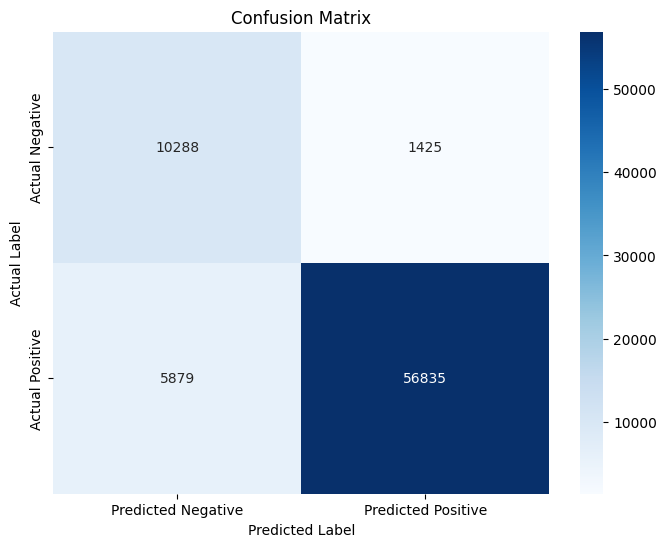

In [11]:
if 'log_model' in locals():
    print("Making predictions on the test set...")

    # Make predictions on the (unbalanced) test data
    y_pred = log_model.predict(X_test_tfidf)

    # 1. Calculate Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

    # 2. Print the Classification Report
    # This gives you precision, recall, and f1-score for both classes
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

    # 3. Display the Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix for a nice visual
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

else:
    print("Model 'log_model' not found. Please run the training block first.")